In [1]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
import string
from sklearn.model_selection import train_test_split
# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
with open('magaza_yorumlari_duygu_analizi.csv',encoding='UTF-16') as f:
    df = pd.read_csv(f)

In [3]:
df.dropna(subset = ["Görüş"], inplace=True)
df.isnull().sum()

Görüş    0
Durum    0
dtype: int64

In [4]:
df = df[df.Durum != 'Tarafsız']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8489 entries, 0 to 11428
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Görüş   8489 non-null   object
 1   Durum   8489 non-null   object
dtypes: object(2)
memory usage: 199.0+ KB


In [6]:
with open('yorumlar.csv') as f:
    df2 = pd.read_csv(f)

In [7]:
df2.dropna(subset = ["Görüş"], inplace=True)
df2.isnull().sum()

Görüş    0
Durum    0
dtype: int64

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2298 entries, 0 to 2297
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Görüş   2298 non-null   object
 1   Durum   2298 non-null   object
dtypes: object(2)
memory usage: 53.9+ KB


In [9]:
df2.head()

,Görüş,Durum
0,Hızlı kargo orjinal ürün zaten hepsi burada gü...,Olumlu
1,ilk başta sıkıntı olmuyor ben 2 tane almıştım ...,Olumsuz
2,güzel,Olumlu
3,Üeün çok güzel kullanışlı ve kibar tavsiye ederim,Olumlu
4,Ürün elime çok hızlı ulaştı. Kargo ve kurye ço...,Olumlu


In [10]:
df.head()

,Görüş,Durum
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",Olumsuz
2,ses olayı süper....gece çalıştır sıkıntı yok.....,Olumlu
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,Olumsuz
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,Olumsuz
6,kullanisli baya,Olumlu


In [11]:
frames = [df, df2]

In [12]:
df = pd.concat(frames)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10787 entries, 0 to 2297
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Görüş   10787 non-null  object
 1   Durum   10787 non-null  object
dtypes: object(2)
memory usage: 252.8+ KB


In [14]:
df['Durum'] = df['Durum'].replace(['Olumsuz','Olumlu'],[int(0),int(1)])
df.head()

,Görüş,Durum
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",0
2,ses olayı süper....gece çalıştır sıkıntı yok.....,1
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,0
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,0
6,kullanisli baya,1


In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
def remove_punc(message):
  Test_punc_removed = []
  for char in message:
    if char not in string.punctuation:
      Test_punc_removed.append(char)
    else:
      Test_punc_removed.append(' ')
  Test_punc_removed_join = ''.join(Test_punc_removed)
  return Test_punc_removed_join

In [17]:
df['Text Without Punctuation'] = df['Görüş'].apply(remove_punc)

In [18]:
df.head()

,Görüş,Durum,Text Without Punctuation
0,"ses kalitesi ve ergonomisi rezalet, sony olduğ...",0,ses kalitesi ve ergonomisi rezalet sony olduğ...
2,ses olayı süper....gece çalıştır sıkıntı yok.....,1,ses olayı süper gece çalıştır sıkıntı yok ...
3,geldi bigün kullandık hemen bozoldu hiçtavsiye...,0,geldi bigün kullandık hemen bozoldu hiçtavsiye...
4,Kulaklığın sesi kaliteli falan değil. Aleti öv...,0,Kulaklığın sesi kaliteli falan değil Aleti öv...
6,kullanisli baya,1,kullanisli baya


In [19]:
nltk.download("stopwords")
stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [20]:
stop_words = stopwords.words('turkish')

In [21]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [22]:
df['Text Without Punc & Stopwords'] = df['Text Without Punctuation'].apply(preprocess)

In [23]:
df['Görüş'][0]

0    ses kalitesi ve ergonomisi rezalet, sony olduğ...
0    Hızlı kargo orjinal ürün zaten hepsi burada gü...
Name: Görüş, dtype: object

In [24]:
df['Text Without Punc & Stopwords'][0]

0    [ses, kalitesi, ergonomisi, rezalet, sony, old...
0    [hızlı, kargo, orjinal, ürün, zaten, burada, g...
Name: Text Without Punc & Stopwords, dtype: object

In [25]:
df['Text Without Punc & Stopwords Joined'] = df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

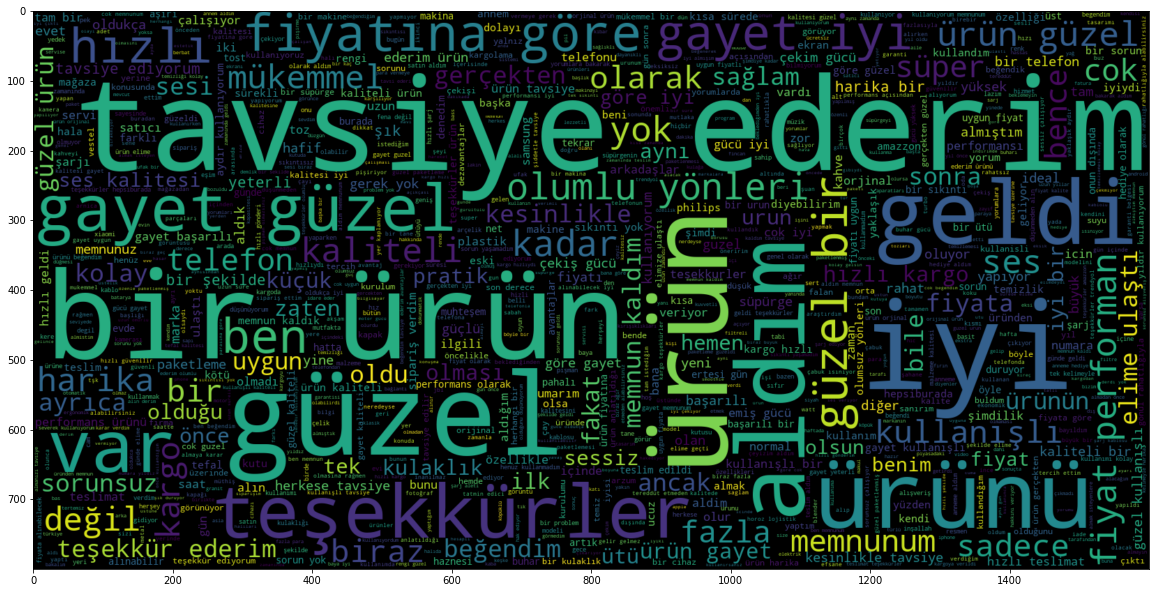

In [26]:
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df[df['Durum'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

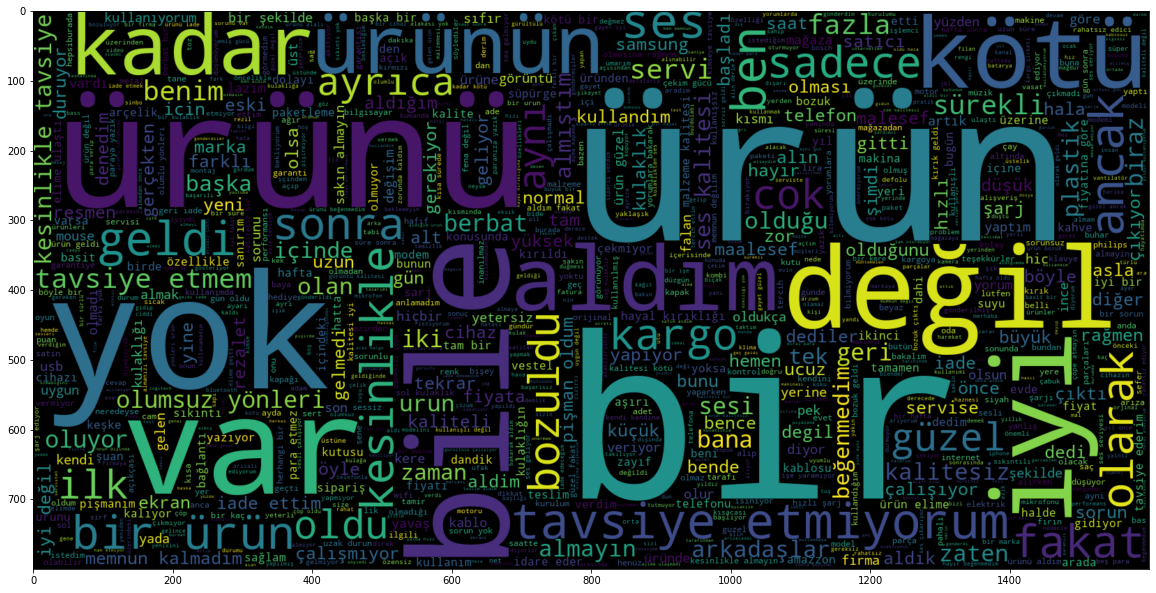

In [27]:
plt.figure(figsize = (20, 20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df[df['Durum'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [29]:
maxlen = -1
for doc in df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 355


In [30]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in df['Text Without Punc & Stopwords Joined'] ]

In [31]:
fig = px.histogram(x = tweets_length, nbins = 50)
fig.show()

In [32]:
list_of_words = []
for i in df['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)

In [33]:
total_words = len(list(set(list_of_words)))
total_words

28741

In [34]:
X = df['Text Without Punc & Stopwords']
y = df['Durum']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [35]:
X_train.shape

(9708,)

In [36]:
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [37]:
print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 1163    [evet, ürün, güzel]
Name: Text Without Punc & Stopwords, dtype: object 
 is:  [205, 2, 4]


In [38]:
padded_train = pad_sequences(train_sequences, maxlen = 55, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 55, truncating = 'post')

In [39]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [10760    18    50  2789  1561 10761 10762  1072    82 10763   355 10764
 10765    75   305     3     1     2   173  5272     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
The padded encoding for document: 2  is: [205   2   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
The padded encoding for document: 3  is: [  196  2510 10766   145  6955    40  1663    40  2511   740   153  1029
    70  1914  4305   541   119   458  1773   202    40  2511  5273 10767
     5    56     1  3639    17   159  3148  2512     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0

In [40]:
y_train.shape

(9708,)

In [41]:
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [42]:
model = Sequential()
# embedding layer
model.add(Embedding(total_words, output_dim = 512, input_length=padded_train.shape[1]))
# Bi-Directional RNN and LSTM
model.add(SpatialDropout1D(0.4))
model.add(LSTM(256,dropout=0.2, recurrent_dropout=0.2))
# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 55, 512)           14715392  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 55, 512)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2

In [43]:
filepath = 'best_model.hdf5'

In [44]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

In [45]:
callbacks = [checkpoint]
history = model.fit(padded_train, y_train_cat, batch_size = 32, validation_data=(padded_test, y_test_cat), epochs = 15, callbacks=callbacks)

Epoch 1/15
304/304 [==============================] - 122s 383ms/step - loss: 0.6970 - acc: 0.5077 - val_loss: 0.6746 - val_acc: 0.7331

Epoch 00001: val_acc improved from -inf to 0.73309, saving model to best_model.hdf5
Epoch 2/15
304/304 [==============================] - 116s 382ms/step - loss: 0.6493 - acc: 0.6032 - val_loss: 0.6869 - val_acc: 0.5134

Epoch 00002: val_acc did not improve from 0.73309
Epoch 3/15
304/304 [==============================] - 114s 376ms/step - loss: 0.6167 - acc: 0.6873 - val_loss: 0.6694 - val_acc: 0.5941

Epoch 00003: val_acc did not improve from 0.73309
Epoch 4/15
304/304 [==============================] - 115s 378ms/step - loss: 0.6125 - acc: 0.6665 - val_loss: 0.5141 - val_acc: 0.7729

Epoch 00004: val_acc improved from 0.73309 to 0.77294, saving model to best_model.hdf5
Epoch 5/15
304/304 [==============================] - 116s 382ms/step - loss: 0.3145 - acc: 0.8835 - val_loss: 0.2999 - val_acc: 0.8832

Epoch 00005: val_acc improved from 0.77294 t

In [46]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

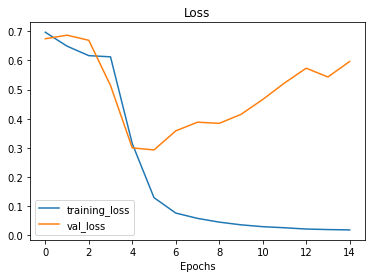

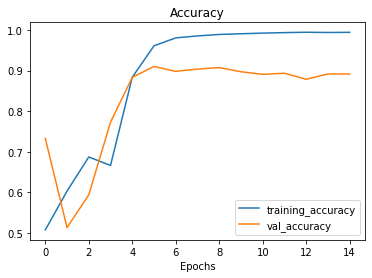

In [47]:
plot_loss_curves(history)

In [48]:
model.load_weights(filepath)

In [49]:
pred = model.predict(padded_test)

In [50]:
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [51]:
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [52]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.9101019462465245

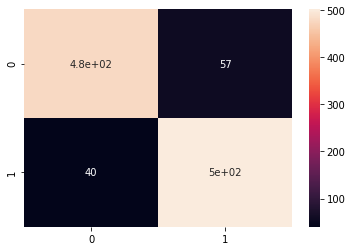

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)

In [59]:
def data_preprocessing(data):
  data = remove_punc(data)
  data = preprocess(data)
  data_sequences = tokenizer.texts_to_sequences(pd.Series([data]))
  padded_data = pad_sequences(data_sequences, maxlen = 55, padding = 'post', truncating = 'post')
  return padded_data

In [ ]:
results = model.predict(data_preprocessing('Ürün aşırı derecede kötü kolundaki beyazlı yerler sararmış kullanılmış gibi göğüs bölgesindeki kumaş ile alakası yok, sağından solundan eziklikler var gibi, ben beğenmedim iade ettim.'))

In [60]:
results = model.predict(data_preprocessing('Çok bir performans beklemeyerek aldım.saten,tül ve jarse kumaşları iyi ütülüyor.tshirt ve benzeri şeylerde de fena depil özellikle aceleniz olduğu zamanlarda'))

In [65]:
inv_dict = {0: 'Olumsuz', 1: 'Olumlu'}
data = 'Baya iyi duruşu var kumaşıda çok rahat'
results = model.predict(data_preprocessing(data))
inv_dict[np.argmax(results[0])]

'Olumlu'